### Importing Necessary Libraries ###

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt


# Exploratory Data Analysis
We're tabulating the data into a Pandas DataFrame in order to seek critical information from the data, such as the weed count and crop count per image. 

Annotation format: YOLOv8
bounding box is specified by [class, x_center, y_center, width, height]
where,
class : 0 - weed, 1 - crop
x_center and y_center specify the center coordinates of the bounding box
width and height specify the respective dimensions of the bounding box

In [3]:
directory = '/kaggle/input/labeled-data-1/labeled/labels'

data = []
for filename in os.listdir(directory):
    if filename.endswith('.txt'):  
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            entries = file.readlines()  
            num_entries = len(entries)  
            weedCount = 0
            cropCount = 0
            for line in entries:
                quintuple = line.strip().split()
                if quintuple[0] == '0':
                    weedCount+=1
                else:
                    cropCount+=1
            data.append([filename, num_entries, weedCount, cropCount])
df = pd.DataFrame(data, columns=['File', 'NumEntries', 'weedCount', 'cropCount'])
df[['NumEntries', 'weedCount', 'cropCount']] = df[['NumEntries', 'weedCount', 'cropCount']].astype(int)


In [4]:
df.head()

,File,NumEntries,weedCount,cropCount
0,agri_0_357_jpeg.rf.499443410f6b53f5c53f8935f7c...,1,0,1
1,agri_0_1882_jpeg.rf.dc545f32ba4f97f5ce6757a039...,1,0,1
2,agri_0_3152_jpeg.rf.d53c00467e2e9eb903a225bc1e...,1,1,0
3,agri_0_7375_jpeg.rf.a72a1ac385ff257bfd8f1e7963...,2,0,2
4,agri_0_6735_jpeg.rf.53ef6fe9bfc3a66b759f2c783e...,3,0,3


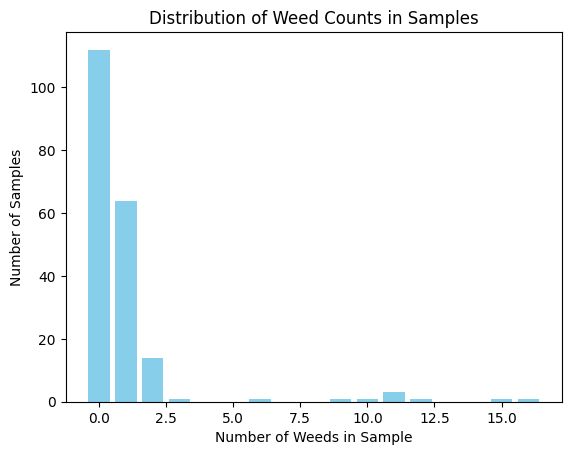

In [9]:
weed_counts = df['weedCount'].value_counts().sort_index()

# Plot bar graph
plt.bar(weed_counts.index, weed_counts.values, color='skyblue')

# Labels and title
plt.xlabel('Number of Weeds in Sample')
plt.ylabel('Number of Samples')
plt.title('Distribution of Weed Counts in Samples')

# Show the plot
plt.show()



The above plot gives us information that generally data samples contain 0, 1, or 2 weeds. But there are a few images containing a very high number of weeds

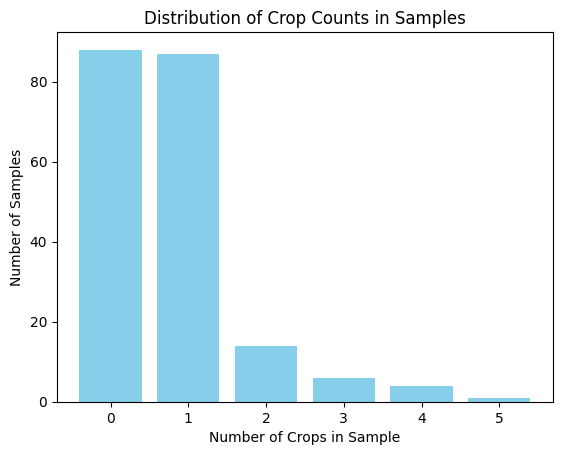

In [8]:
crop_counts = df['cropCount'].value_counts().sort_index()

# Plot bar graph
plt.bar(crop_counts.index, crop_counts.values, color='skyblue')

# Labels and title
plt.xlabel('Number of Crops in Sample')
plt.ylabel('Number of Samples')
plt.title('Distribution of Crop Counts in Samples')

# Show the plot
plt.show()

Nearly all images either contain 0 or 1 crop, with a few images having higher than that


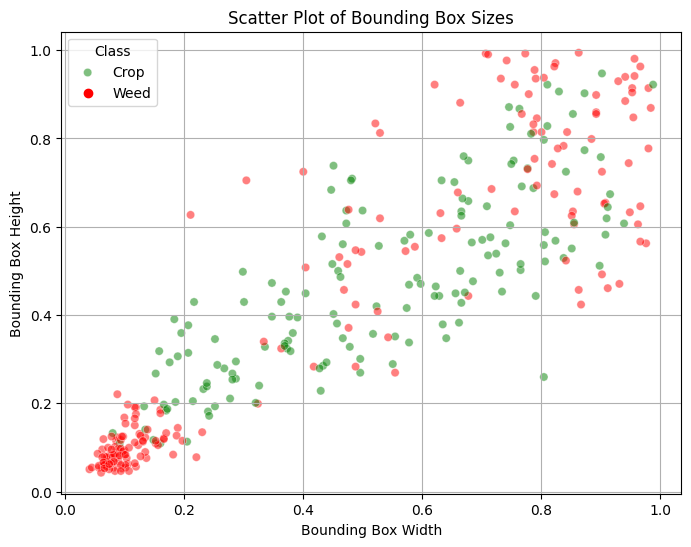

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

directory = '/kaggle/input/labeled-data-1/labeled/labels'

bbox_data = []

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            for line in file:
                values = line.strip().split()
                class_id = int(values[0])  # Class (0=weed, 1=crop)
                x_center, y_center, width, height = map(float, values[1:])

                # Store bounding box width, height along with class
                bbox_data.append([filename, class_id, width, height])

# Create DataFrame
bbox_df = pd.DataFrame(bbox_data, columns=['File', 'Class', 'BBox_Width', 'BBox_Height'])

# Plot scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=bbox_df, x='BBox_Width', y='BBox_Height', hue='Class', alpha=0.5, palette={0: 'red', 1: 'green'})
plt.xlabel('Bounding Box Width')
plt.ylabel('Bounding Box Height')
plt.title('Scatter Plot of Bounding Box Sizes')
plt.legend(title="Class", labels=["Crop", "Weed"])
plt.grid(True)
plt.show()


This shows that a majority of weeds are quite small in size, and the crop sizes are evenly spread

In [10]:
total1 = df['weedCount'].sum()
total2 = df['cropCount'].sum()

print(total1," ", total2)

196   154


# Data Preprocessing

### Since the number of our labeled images is less (only 200), we need to introduce more data: an effective way to do this by augmenting (altering) the original data images and including them in the labeled data


The Albumentations library is a powerful tool for including augmentations

In [11]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [13]:
import albumentations as A
import cv2

#### Also, we are not using augmentations that involve shifting, rotating or cropping - as they will change the bounding box coordinates of the augmented image, and we won't be able to use the same labels for them as the original image

The below function contains an augmentation pipline, which it will apply to each image in the dataset
**num_augmentation** times, and write all the augmented images obtained plus the original image into a new dataset.

Thus, the number of images in our augmented dataset will be equal to:

#images_final = #images * (1 + num_augmentations)

Thus, setting num_augmentations = 5 yields us a dataset of size 1200 images, which is sufficient for our task.

## Augmentation Pipeline used:
Some of the functions that we used are:
1. RandomBrightnessContrast() : This either changes the brightness or the contrast of the provided image upto a certain limit.
2. MotionBlur() and GaussianBlur() : Introduces blur to the image - important as photographed images may get blurry
3. RandomFog() and RandomRain() : Changes the weather effects of the background, again boosts the robustness of the model.

In [14]:
# FUNCTION TO INCLUDE AUGMENTED IMAGES

import albumentations as A
import cv2
import os
import shutil
import numpy as np
from pathlib import Path

def create_augmented_dataset(
    original_images_path,
    original_labels_path,
    output_dir,
    num_augmentations
):
    """
    Create augmented dataset and return the path to the new dataset

    Args:
        original_images_path: Path to original images
        original_labels_path: Path to original labels
        output_dir: Directory to save augmented dataset
        num_augmentations: Number of augmentations per image

    Returns:
        str: Absolute path to the augmented dataset directory
    """

    # Convert to absolute paths
    output_dir = os.path.abspath(output_dir)
    output_images_dir = os.path.join(output_dir, 'images')
    output_labels_dir = os.path.join(output_dir, 'labels')

    # Create output directories if they don't exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    # Define augmentation pipeline
    transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.1, p=0.4),
        A.RandomRain(brightness_coefficient=0.8, drop_width=1, blur_value=3, p=0.3),
        A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=1.5, p=0.2),
        A.MotionBlur(blur_limit=7, p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.GaussNoise(var_limit=(10, 50), p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    ])

    # First, copy original dataset
    image_files = [f for f in os.listdir(original_images_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    # Copy original images and labels
    for img_file in image_files:
        # Copy original image
        shutil.copy2(
            os.path.join(original_images_path, img_file),
            os.path.join(output_images_dir, img_file)
        )

        # Copy corresponding label file (assuming same name, different extension)
        label_file = Path(img_file).stem + '.txt'  # Adjust extension if needed
        if os.path.exists(os.path.join(original_labels_path, label_file)):
            shutil.copy2(
                os.path.join(original_labels_path, label_file),
                os.path.join(output_labels_dir, label_file)
            )

    # Create augmented images and copy labels
    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(original_images_path, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image: {img_file}")
            continue

        # Get corresponding label file
        label_file = Path(img_file).stem + '.txt'

        # Create augmented versions
        for aug_idx in range(num_augmentations):
            # Create augmented image
            augmented = transform(image=img)
            aug_img = augmented['image']

            # Generate new filename
            base_name = Path(img_file).stem
            aug_img_name = f"{base_name}_aug_{aug_idx}{Path(img_file).suffix}"
            aug_label_name = f"{base_name}_aug_{aug_idx}.txt"

            # Save augmented image
            cv2.imwrite(
                os.path.join(output_images_dir, aug_img_name),
                aug_img
            )

            # Copy corresponding label file with new name
            if os.path.exists(os.path.join(original_labels_path, label_file)):
                shutil.copy2(
                    os.path.join(original_labels_path, label_file),
                    os.path.join(output_labels_dir, aug_label_name)
                )

        # Print progress
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(image_files)} original images")

    # Count total images in new dataset
    final_count = len(os.listdir(output_images_dir))
    print(f"Augmentation complete. Total images in new dataset: {final_count}")
    print(f"Dataset path: {output_dir}")

    return output_dir


In [15]:


dataset_path = "/kaggle/input/labeled-data-1/labeled"
train_images = os.path.join(dataset_path, "images")
# val_images = "/content/drive/MyDrive/sesame-weed-detection-competition/test/images"
labels_dir = os.path.join(dataset_path, "labels")
output_dir = "/kaggle/working/augmented_dataset"
# Create augmented dataset and get the path
augmented_dataset_path = create_augmented_dataset(
    train_images,
    labels_dir,
    output_dir,
    num_augmentations=5
)

Processed 10/200 original images
Processed 20/200 original images
Processed 30/200 original images
Processed 40/200 original images
Processed 50/200 original images
Processed 60/200 original images
Processed 70/200 original images
Processed 80/200 original images
Processed 90/200 original images
Processed 100/200 original images
Processed 110/200 original images
Processed 120/200 original images
Processed 130/200 original images
Processed 140/200 original images
Processed 150/200 original images
Processed 160/200 original images
Processed 170/200 original images
Processed 180/200 original images
Processed 190/200 original images
Processed 200/200 original images
Augmentation complete. Total images in new dataset: 1200
Dataset path: /kaggle/working/augmented_dataset


We have successfully created the augmented dataset - all that needs to be done is to save this to our local machine